# 基于K-means聚类算法进行超市客户人群分析


## 实验内容


在本案例中，我们使用人工智能技术的聚类算法去分析超市购物中心客户的一些基本数据，把客户分成不同的群体，供营销团队参考并相应地制定营销策略。

我们使用的数据集是超市用户会员卡的基本数据以及根据购物行为得出的消费指数，总共有5个字段，解释如下：

* CustomerID：客户ID
* Gender：年龄
* Age：年龄
* Annual Income (k$)：年收入
* Spending Score (1-100)：消费指数


## 实验步骤

### 进入ModelArts界面

点击如下链接：https://www.huaweicloud.com/product/modelarts.html ，进入ModelArts主页。点击“立即使用”按钮，输入用户名和密码登录，进入ModelArts使用页面。

### 创建ModelArts Notebook

下面，我们在ModelArts中创建一个notebook开发环境，ModelArts notebook提供网页版的Python开发环境，可以方便的编写、运行代码，并查看运行结果。

第一步：在ModelArts服务主界面依次点击“开发环境”、“创建”

![create_nb_create_button](./img/create_nb_create_button.png)

第二步：填写notebook所需的参数：

| 参数 | 说明 |
| - - - - - | - - - - - |
| 计费方式 | 按需计费  |
| 名称 | Notebook实例名称，如 kmeans_customer_segmentation |
| 工作环境 | Python3 |
| 资源池 | 选择"公共资源池"即可 |
| 类型 | CPU |
| 规格 | 2核8GiB |
| 存储配置 | 选择EVS，磁盘规格5GB |

第三步：配置好notebook参数后，点击下一步，进入notebook信息预览。确认无误后，点击“立即创建”

![create_nb_creation_summary](./img/create_nb_creation_summary.png)

第四步：创建完成后，返回开发环境主界面，等待Notebook创建完毕后，打开Notebook，进行下一步操作。
![modelarts_notebook_index](./img/modelarts_notebook_index.png)

### 在ModelArts中创建开发环境

接下来，我们创建一个实际的开发环境，用于后续的实验步骤。

第一步：点击下图所示的“打开”按钮，进入刚刚创建的Notebook
![inter_dev_env](img/enter_dev_env.png)

第二步：创建一个Python3环境的的Notebook。点击右上角的"New"，然后创建 XGBoost-Sklearn 开发环境。

第三步：点击左上方的文件名"Untitled"，并输入一个与本实验相关的名称，如"kmeans_customer_segmentation"
![notebook_untitled_filename](./img/notebook_untitled_filename.png)
![notebook_name_the_ipynb](./img/notebook_name_the_ipynb.png)


### 在Notebook中编写并执行代码

在Notebook中，我们输入一个简单的打印语句，然后点击上方的运行按钮，可以查看语句执行的结果：
![run_helloworld](./img/run_helloworld.png)


开发环境准备好啦，接下来可以愉快地写代码啦！


### 初始化ModelArts SDK

In [1]:
from modelarts.session import Session
import os
session = Session()

###  准备源代码和数据

这步准备案例所需的源代码和数据，相关资源已经保存在OBS中，我们通过ModelArts SDK将资源下载到本地，并解压到当前目录下。解压后，当前目录包含data和src两个目录，分别存有数据集和源代码。

In [2]:
if not os.path.exists('./data'):
    session.download_data(bucket_path='ai-course-common-20/kmeans_customer_segmentation/kmeans_customer_segmentation.tar.gz',
                         path='./kmeans_customer_segmentation.tar.gz')

    # 使用tar命令解压资源包
    !tar xf ./kmeans_customer_segmentation.tar.gz
    
    # 清理压缩包
    !rm -f ./diabetes_prediciton.tar.gz

### 导入工具库

matplotlib和seaborn是Python绘图工具，pandas和numpy是矩阵运算工具。

此段代码只是引入Python包，无回显（代码执行输出）。

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.cluster import KMeans
import warnings
import os
warnings.filterwarnings("ignore")

### 数据读取
使用pandas.read_excel(filepath)方法读取notebook中的数据文件。
* filepath：数据文件路径

In [4]:
df = pd.read_csv('data/Mall_Customers.csv')

### 展示样本数据

执行这段代码可以看到数据集的5个样本数据

In [5]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


执行这段代码可以看到数据集的维度

In [6]:
df.shape

(200, 5)

### 展示各个字段的统计值信息

调用pandas.DataFrame.describe方法，可以看到各个特征的统计信息，包括样本数、均值、标准差、最小值、1/4分位数、1/2分位数、3/4分位数和最大值。

In [7]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


### 展示各个字段的数据类型

pandas.DataFrame.dtypes()方法可以展示各个字段的类型信息。

可以看到每个字段的类型信息。

In [8]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

查看是否有数据缺失，如果有，则需要填补。

实验中使用的这份数据很完善，没有任何一个属性的值为null，因此统计下来，null值的数量都是0

In [9]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

### 展示主要属性的数量分布

这段代码使用matplotlib绘制了数据中三个主要属性的统计直方图，包含年龄、收入、消费指数。

可以看到三张统计直方图，形状都与正态分布类似，说明数据量足够，数据抽样的分布也比较理想。

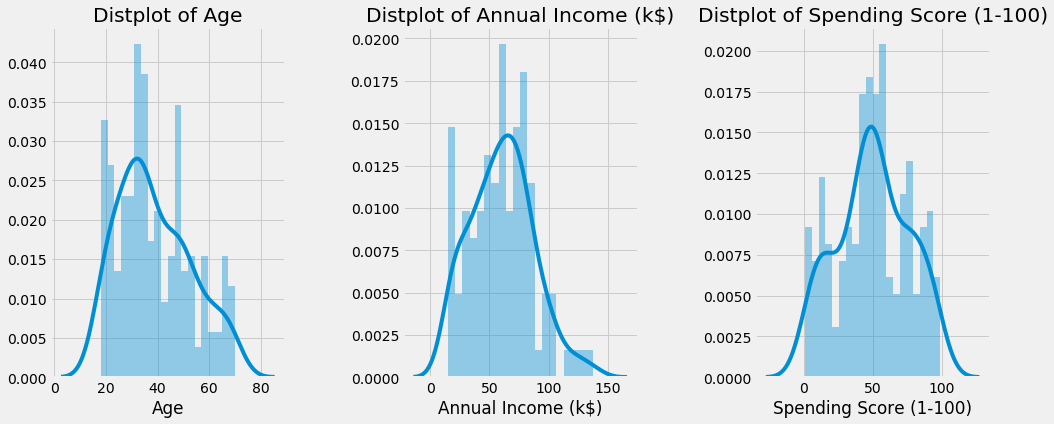

In [10]:
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

### 展示男、女客户数量的分布

这段代码使用matplotlib绘制条状图，展示男、女样本数量的分布。

可以看到一张条状图。

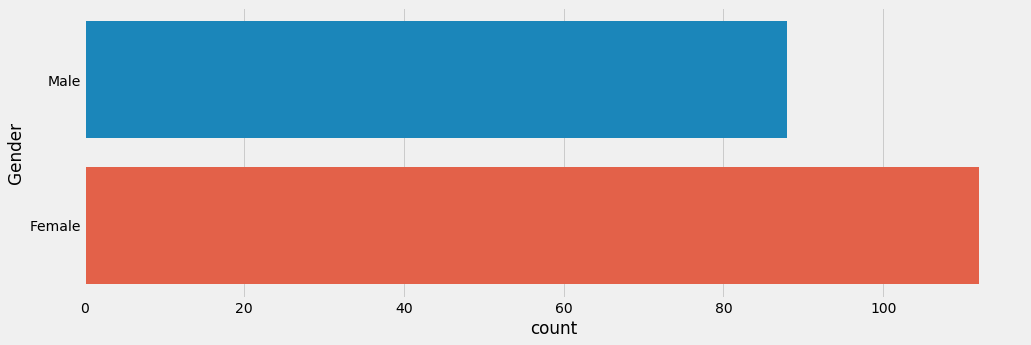

In [11]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'Gender' , data = df)
plt.show()

### 观察不同属性之间的关系

展示任意两个属性之间的统计关系图。

此段代码执行后，会有9张统计图，展示了任意两个属性之间的统计关系。

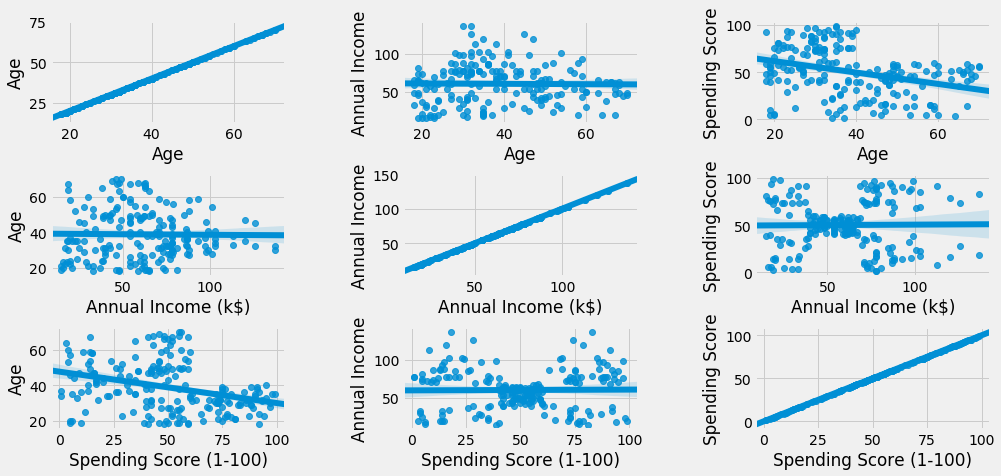

In [12]:
plt.figure(1 , figsize = (15 , 7))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    for y in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
        n += 1
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )
plt.show()

此段代码执行后，会有1张统计图，以性别为参照，展示了年龄和收入之间的对应统计关系

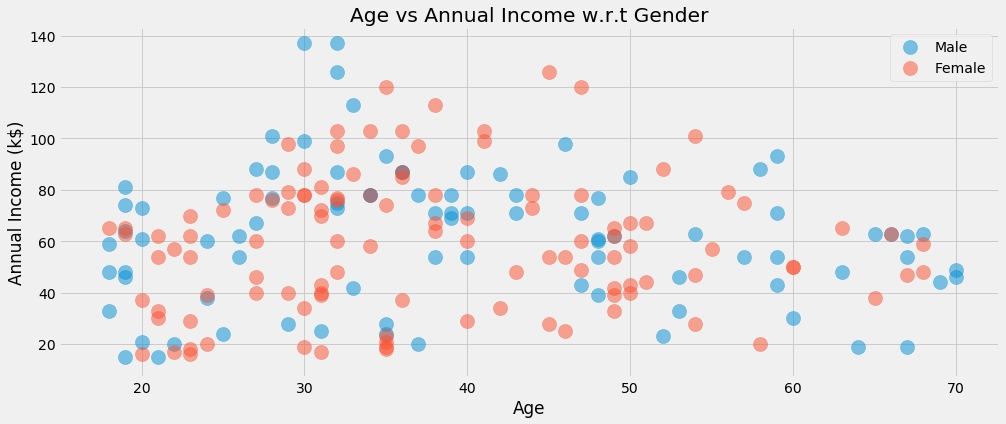

In [13]:
plt.figure(1 , figsize = (15 , 6))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Age' , y = 'Annual Income (k$)' , data = df[df['Gender'] == gender] ,
                s = 200 , alpha = 0.5 , label = gender)
plt.xlabel('Age'), plt.ylabel('Annual Income (k$)') 
plt.title('Age vs Annual Income w.r.t Gender')
plt.legend()
plt.show()

此段代码执行后，会有1张统计图，以性别为参照，展示了收入和消费指数之间的对应统计关系

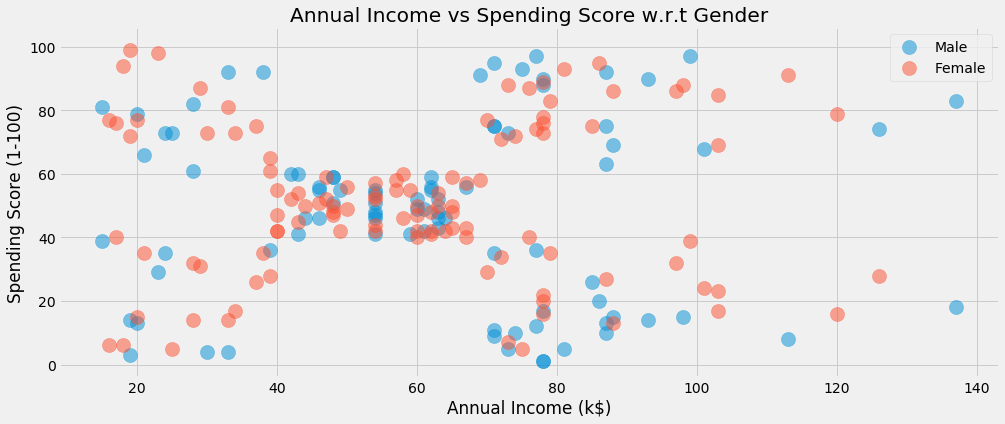

In [14]:
plt.figure(1 , figsize = (15 , 6))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Annual Income (k$)',y = 'Spending Score (1-100)' ,
                data = df[df['Gender'] == gender] ,s = 200 , alpha = 0.5 , label = gender)
plt.xlabel('Annual Income (k$)'), plt.ylabel('Spending Score (1-100)') 
plt.title('Annual Income vs Spending Score w.r.t Gender')
plt.legend()
plt.show()

### 观察不同性别的客户的数据分布

观察不同性别的客户的数据，在年龄、年收入、消费指数上的分布。

此段代码执行后，会有六幅boxplot图像。

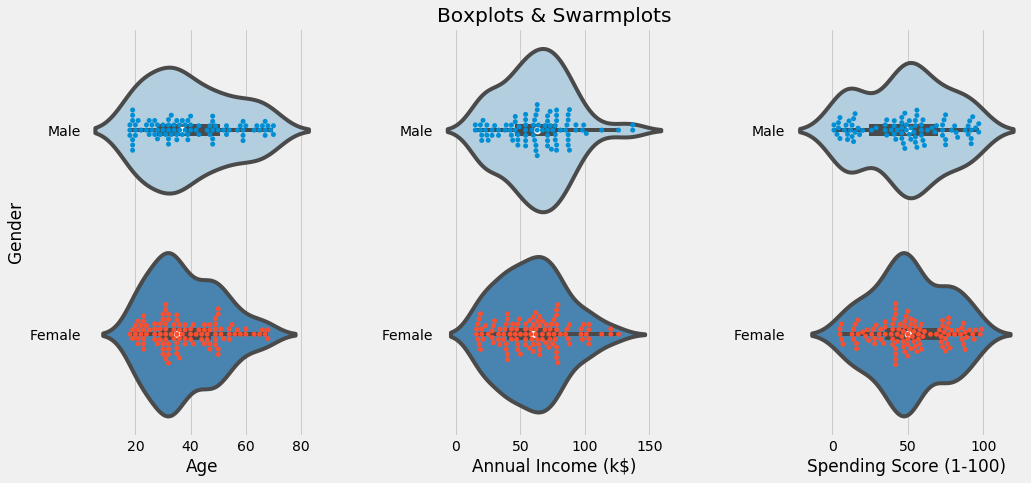

In [15]:
plt.figure(1 , figsize = (15 , 7))
n = 0 

for cols in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1 
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.violinplot(x = cols , y = 'Gender' , data = df, palette='Blues')
    sns.swarmplot(x = cols , y = 'Gender' , data = df)
    plt.ylabel('Gender' if n == 1 else '')
    plt.title('Boxplots & Swarmplots' if n == 2 else '')
plt.show()

### 使用 K-means 对数据进行聚类

根据年龄和消费指数进行聚类和区分客户。

我们使用1-10个聚类中心进行聚类。（此段代码无输出）

In [16]:
'''Age and spending Score'''
X1 = df[['Age' , 'Spending Score (1-100)']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

观察10次聚类的inertias，并以如下折线图进行统计。

inertias是K-Means模型对象的属性，它作为没有真实分类结果标签下的非监督式评估指标。表示样本到最近的聚类中心的距离总和。值越小越好，越小表示样本在类间的分布越集中。

可以看到，当聚类中心大于等于4之后，inertias的变化幅度显著缩小了。

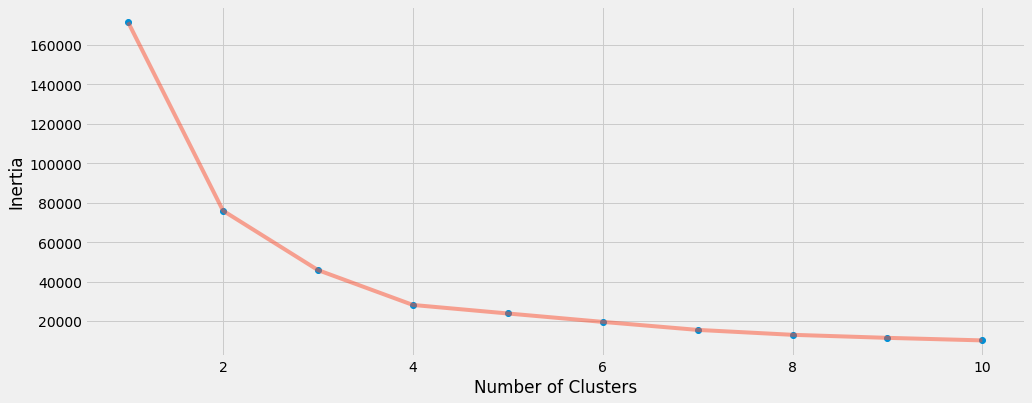

In [17]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

我们使用4个聚类中心再次进行聚类。（此段代码无输出）

In [18]:
algorithm = (KMeans(n_clusters = 4 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

我们把4个聚类中心的聚类结果，以下图进行展示。横坐标是年龄，纵坐标是消费指数，4个红点为4个聚类中心，4块不同颜色区域就是4个不同的用户群体。

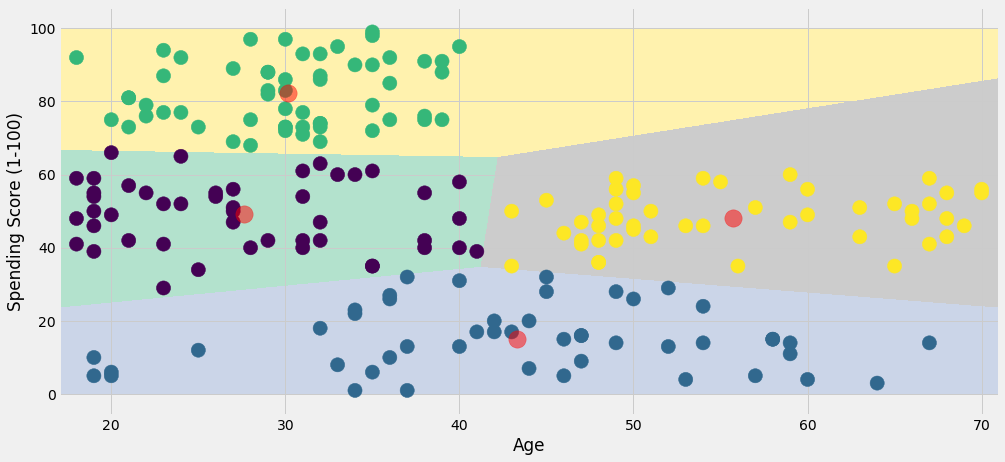

In [19]:
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Age' ,y = 'Spending Score (1-100)' , data = df , c = labels1 , 
            s = 200 )
plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Age')
plt.show()

根据年收入和消费指数进行聚类和区分客户。

我们使用1-10个聚类中心进行聚类。（此段代码无输出）

In [20]:
'''Annual Income and spending Score'''
X2 = df[['Annual Income (k$)' , 'Spending Score (1-100)']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X2)
    inertia.append(algorithm.inertia_)

观察10次聚类的inertias，并以如下折线图进行统计。

可以看到，当聚类中心大于等于5之后，inertias的变化幅度显著缩小了。

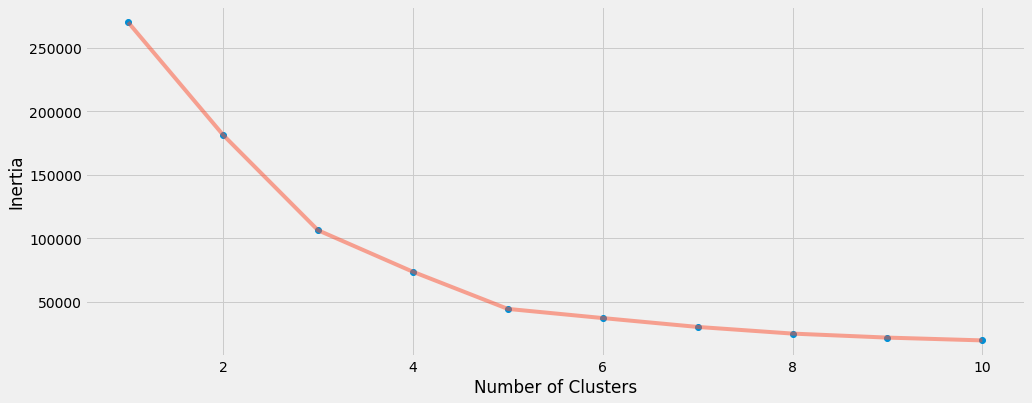

In [21]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

我们使用5个聚类中心再次进行聚类。（此段代码无输出）

In [22]:
algorithm = (KMeans(n_clusters = 5 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X2)
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

我们把5个聚类中心的聚类结果，以下图进行展示。横坐标是年收入，纵坐标是消费指数，5个红点为5个聚类中心，5块不同颜色区域就是5个不同的用户群体。

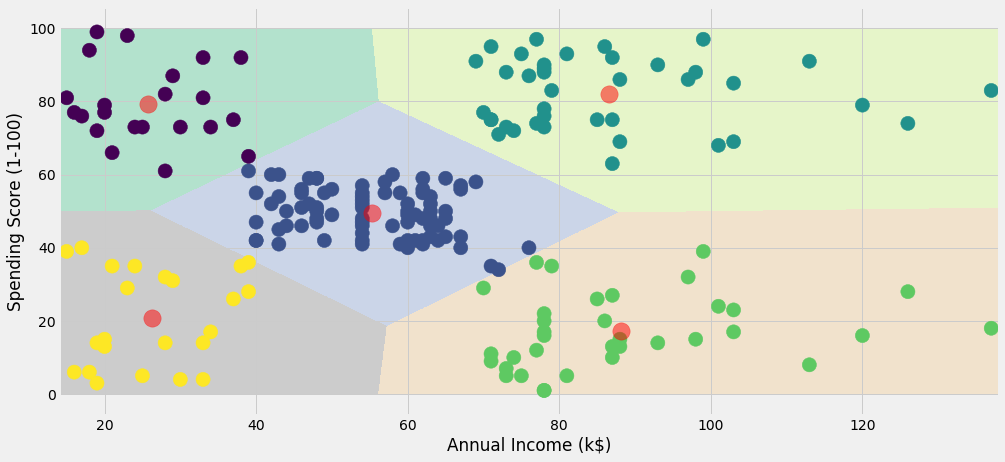

In [23]:
h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z2 = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z2.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Annual Income (k$)' ,y = 'Spending Score (1-100)' , data = df , c = labels2 , 
            s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Annual Income (k$)')
fig = plt.gcf()

plt.show()